In [3]:
import matplotlib.pyplot as plt 
from matplotlib.markers import MarkerStyle 
import numpy as np 
from tensorflow.keras import backend as K 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Lambda, Input, Dense 
from tensorflow.keras.losses import binary_crossentropy 
from tensorflow.keras.models import Model

In [4]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1] * x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size]) 
x_test = np.reshape(x_test, [-1, image_size]) 
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255 

In [23]:
def build_vae(intermediate_dim=1024, latent_dim=2):    
    """    Build VAE    
    :param intermediate_dim: size of hidden layers of the encoder/decoder    
    :param latent_dim: latent space size    
    :returns tuple: the encoder, the decoder, and the full vae    """
    # encoder first    
    inputs = Input(shape=(image_size,), name='encoder_input')   
    x = Dense(intermediate_dim, activation='relu')(inputs)
    # latent mean and variance    
    z_mean = Dense(latent_dim, name='z_mean')(x)    
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # reparameterization trick for random sampling    
    # Note the use of the Lambda layer    
    # At runtime, it will call the sampling function    
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    # full encoder encoder model    
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')    
    encoder.summary()
    # decoder    
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')    
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)    
    outputs = Dense(image_size, activation='sigmoid')(x)
    # full decoder model    
    decoder = Model(latent_inputs, outputs, name='decoder')    
    decoder.summary()
    # VAE model   
    outputs = decoder(encoder(inputs)[2])    
    vae = Model(inputs, outputs, name='vae')
    # Loss function    
    # we start with the reconstruction loss    
    reconstruction_loss = binary_crossentropy(inputs, outputs) * image_size
    # next is the KL divergence
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)    
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss *= -0.5
    # we combine them in a total loss    
    vae_loss = K.mean(reconstruction_loss + kl_loss)    
    vae.add_loss(vae_loss)
    return encoder, decoder, vae

In [24]:
def sampling(args: tuple):    
    """    Reparameterization trick by sampling z from unit Gaussian    
    :param args: (tensor, tensor) mean and log of variance of q(z|x)    
    :returns tensor: sampled latent vector z    """
    # unpack the input tuple    
    z_mean, z_log_var = args
    # mini-batch size   
    mb_size = K.shape(z_mean)[0]
    # latent space size    
    dim = K.int_shape(z_mean)[1]
    # random normal vector with mean=0 and std=1.0    
    epsilon = K.random_normal(shape=(mb_size, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [25]:
def plot_latent_distribution(encoder, x_test, y_test, batch_size=128):
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)   
    plt.figure(figsize=(6, 6))
    markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 's', 'p')
    for i in np.unique(y_test):       
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],                    
                    marker=MarkerStyle(markers[i], fillstyle='none'),edgecolors='black')
    plt.xlabel("z[0]")    
    plt.ylabel("z[1]")   
    plt.show()

In [26]:
def plot_generated_images(decoder):    
    """    Display a 2D plot of the generated images.    
    We only need the decoder, because we'll manually sample the distribution z    
    :param decoder: the decoder network    """
    # display a nxn 2D manifold of digits    
    n = 15    
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))    
    # linearly spaced coordinates corresponding to the 2D plot    
    # of digit classes in the latent space    
    grid_x = np.linspace(-4, 4, n)    
    grid_y = np.linspace(-4, 4, n)[::-1]
    # start sampling z1 and z2 in the ranges grid_x and grid_y    
    for i, yi in enumerate(grid_y):        
        for j, xi in enumerate(grid_x):

            z_sample = np.array([[xi, yi]])            
            x_decoded = decoder.predict(z_sample)            
            digit = x_decoded[0].reshape(digit_size, digit_size)            
            slice_i = slice(i * digit_size, (i + 1) * digit_size)            
            slice_j = slice(j * digit_size, (j + 1) * digit_size)            
            figure[slice_i, slice_j] = digit
    # plot the results    
    plt.figure(figsize=(6, 5))    
    start_range = digit_size // 2    
    end_range = n * digit_size + start_range + 1    
    pixel_range = np.arange(start_range, end_range, digit_size)    
    sample_range_x = np.round(grid_x, 1)    
    sample_range_y = np.round(grid_y, 1)    
    plt.xticks(pixel_range, sample_range_x)    
    plt.yticks(pixel_range, sample_range_y)    
    plt.xlabel("z[0]")    
    plt.ylabel("z[1]")    
    plt.imshow(figure, cmap='Greys_r')    
    plt.show()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 1024)         803840      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            2050        dense_15[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            2050        dense_15[0][0]                   
____________________________________________________________________________________________

W0724 13:19:13.222589 15384 training_utils.py:1237] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 807940      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          806672      encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_clip_by_value_4/Min [(None, 784)]        0           decoder[1][0]                    
________________________________________________________________________________________________

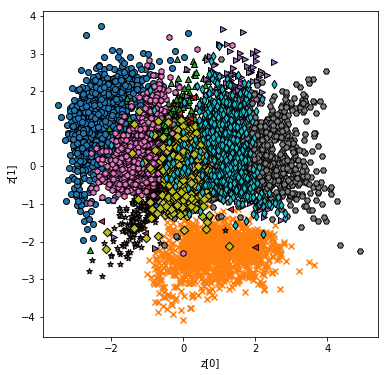

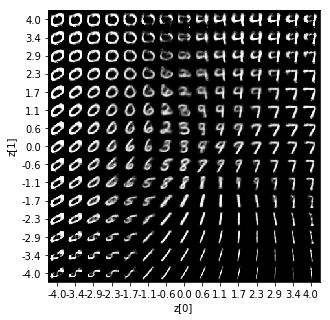

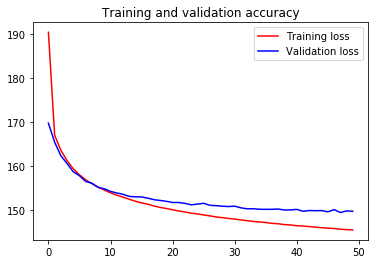

<Figure size 432x288 with 0 Axes>

In [27]:
if __name__ == '__main__': 
    encoder, decoder, vae = build_vae()
    vae.compile(optimizer='adam') 
    vae.summary()
    history=vae.fit(x_train, epochs=50, batch_size=128,verbose = 1, validation_data=(x_test, None))
    plot_latent_distribution(encoder, x_test, y_test, batch_size=512)
    plot_generated_images(decoder)
    # acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()